In [17]:
1 # Design of Variational Autoencoders
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras.datasets import mnist
from keras.losses import binary_crossentropy
from keras.utils import plot_model
from keras import backend as k
import numpy as np
import matplotlib.pyplot as plt
import os 



In [18]:
# MNIST Data Set
(x_train, y_train), (x_test, y_test) = mnist.load_data()
image_size = x_train.shape[1]
original_dim = image_size * image_size # Since we have 28 * 28 pixels
x_train = np.reshape(x_train,[-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train= x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

In [ ]:
print(image_size)
print(x_train.shape[1])

In [19]:
# Network Parameters
input_shape = (original_dim, ) # 28 *28 =784
intermediate_dim = 512
batch_size = 128
latent_dim = 2
epochs = 50

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense_37 (Dense)                (None, 512)          401920      encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            1026        dense_37[0][0]                   
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            1026        dense_37[0][0]                   
____________________________________________________________________________________________

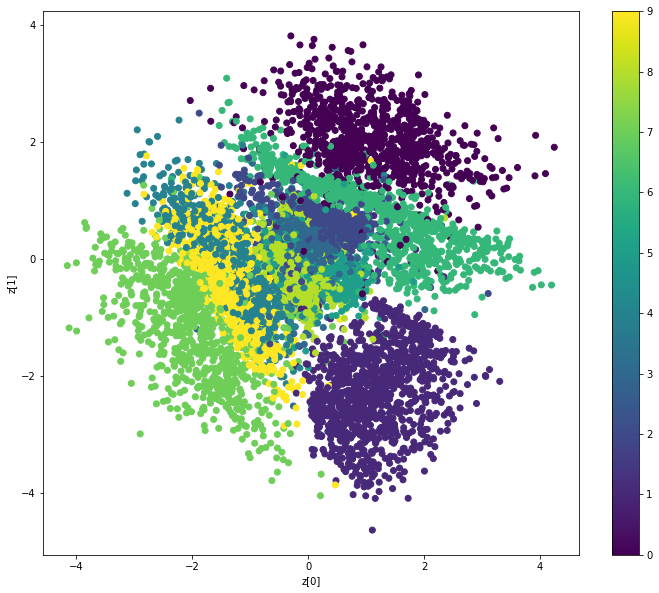

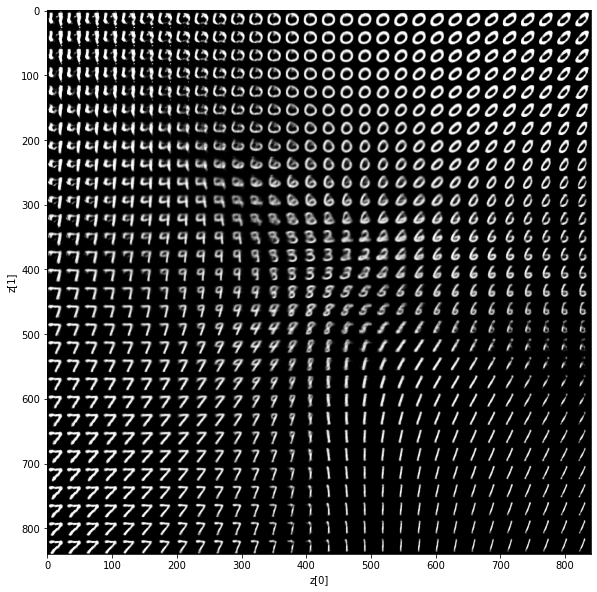

In [30]:
# Create a Variational Autoencoder model = encoder + decoder
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

def sampling(args):
  z_mean, z_log_var = args
  batch = k.shape(z_mean)[0]
  dim = k.int_shape(z_mean)[1]
  epsilon = k.random_normal(shape=(batch, dim))
  return z_mean + k.exp(0.5 * z_log_var) * epsilon

def plot_results(models, data, batch_size=128, model_name='VAE_MNIST'):
  encoder, decoder = models
  x_test, y_test = data
  os.makedirs(model_name, exist_ok=True)
  filename = os.path.join(model_name, "vae_mean.png")
  z_mean, _, _ = encoder.predict(x_test, batch_size=batch_size)
  print(z_mean)

  plt.figure(figsize=(12,10))
  plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
  plt.colorbar()
  plt.xlabel("z[0]")
  plt.ylabel("z[1]")
  plt.savefig(filename)
  plt.show()

  filename = os.path.join(model_name, "digits_with_latent_variable.png")
  n = 30
  digit_size = 28
  figure = np.zeros((digit_size * n, digit_size * n))
  grid_x = np.linspace(-4, 4, n)
  grid_y = np.linspace(-4, 4, n)[::-1]

  for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
      z_sample = np.array([[xi, yi]])
      x_decoded = decoder.predict(z_sample)
      digit = x_decoded[0].reshape(digit_size, digit_size)
      figure[i * digit_size: (i + 1) * digit_size, j * digit_size: (j+1) * digit_size] =digit

  plt.figure(figsize=(10, 10))
  start_range = digit_size // 2
  end_range = (n-1) * digit_size + start_range + 1
  pixel_range = np.arange(start_range, end_range, digit_size)
  sample_range_x = np.round(grid_x, 1)
  sample_range_x = np.round(grid_y, 1)
  plt.xlabel("z[0]")
  plt.ylabel("z[1]")
  plt.imshow(figure, cmap='Greys_r')
  plt.savefig(filename)
  plt.show()





# Reparameterization Trick
z = Lambda(sampling, output_shape=(latent_dim, ), name='z')([z_mean, z_log_var])

# Initialize the encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

# Plot the Encode model

plot_model(encoder, to_file='vae_encoder.png', show_shapes=True)

# Create a Decoder model
latent_inputs = Input(shape=(latent_dim, ), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)

# Initialize the Decoder model.
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

# Plot the Decoder model.
plot_model(decoder, to_file='vae_decoder.png', show_shapes=True)

# Initialize the Variational Autoencoder
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='VariationalAutoEncoder')

if __name__ == '__main__':
  models = (encoder, decoder)
  data = (x_test, y_test)
  reconstruction_loss = binary_crossentropy(inputs, outputs)
  reconstruction_loss = reconstruction_loss * original_dim
  kl_loss = 1 + z_log_var - k.square(z_mean) - k.exp(z_log_var)
  kl_loss = k.sum(kl_loss, axis=-1)
  kl_loss = kl_loss * -0.5
  vae_loss = k.mean(reconstruction_loss + kl_loss)
  vae.add_loss(vae_loss)
  vae.compile(optimizer='adam')
  vae.summary()
 # plot_model(vae, to_file='vae_enc_dec.png', show_shapes=True)
 # plot_model(vae, to_file='vae_enc_dec.png', show_shapes=True)

  # Train the autoencoder
  vae.fit(x_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, None))
  vae.save_weights('vae_mlp_mnist.h5')

  plot_results(models, data, batch_size=batch_size, model_name='vae_model')